In [1]:
import os, sys
import json
import pandas as pd
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import gensim
from gensim import corpora
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Constructed Dataset

In [2]:
path = "./data/"
all_abstracts = pd.read_csv(os.path.join(path, "all-abstracts-labeled.csv"))
all_abstracts

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,abstract,authors,institutions,conference,date,industry
0,"""I Can’t Reply with That"": Characterizing Prob...","In email interfaces, providing users with repl...","['Ronald Robertson', 'Alexandra Olteanu', 'Fer...",Microsoft,CHI Conference on Human Factors in Computing S...,2021-05-01,True
1,"""The human body is a black box"": supporting cl...",Machine learning technologies are increasingly...,"['Mark Sendak', 'Madeleine Clare Elish', 'Mich...","['Duke Institute for Health Innovation', 'Data...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
2,“I Don't Want Someone to Watch Me While I'm Wo...,Employers are increasingly using information a...,"['Luke Stark', 'Amanda Stanhaus', 'Denise L. A...",Microsoft,Journal of the Association for Information Sci...,2020-03-10,True
3,50 Years of Test (Un)fairness: Lessons for Mac...,Quantitative definitions of what is unfair and...,"['Ben Hutchinson', 'Margaret Mitchell']","['Google', 'Google']",FAT* '19: Proceedings of the Conference on Fai...,January 2019,True
4,50 Years of Test (Un)fairness: Lessons for Mac...,Quantitative definitions of what is unfair and...,['Ben Hutchinson'],Google,Proceedings of FAT* 2019.,2019,True
...,...,...,...,...,...,...,...
314,"Whose side are ethics codes on?: power, respon...",The moral authority of ethics codes stems from...,"['Anne L. Washington', 'Rachel Kuo']","['New York University', 'New York University']",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
315,Whose tweets are surveilled for the police: an...,Social media monitoring by law enforcement is ...,"['Glencora Borradaile', 'Brett Burkhardt', 'Al...","['Oregon State University', 'Oregon State Univ...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,False
316,Why does my model fail?: contrastive local exp...,"In various business settings, there is an inte...","['Ana Lucic', 'Hinda Haned', 'Maarten de Rijke']","['University of Amsterdam, Amsterdam, Netherla...",FAT* '20: Proceedings of the 2020 Conference o...,January 2020,True
317,Why Reliabilism Is Not Enough:Epistemic and Mo...,In this paper we argue that standard calls for...,['Ben Hutchinson'],Google,AIES 2020 (2020),2020,True


In [3]:
path = "data/"
all_abstracts = pd.read_csv(path + "all-abstracts-labeled.csv")
industry = list(all_abstracts[all_abstracts['industry'] == True]['abstract'])
academia = list(all_abstracts[all_abstracts['industry'] == False]['abstract'])
full_dataset = industry + academia

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling

In [4]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

academia_clean = [clean(doc).split() for doc in academia]
industry_clean = [clean(doc).split() for doc in industry]
full_clean = [clean(doc).split() for doc in full_dataset]

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
academia_dict = corpora.Dictionary(academia_clean)
industry_dict = corpora.Dictionary(industry_clean)
full_dict = corpora.Dictionary(full_clean)
academia_term_matrix = [academia_dict.doc2bow(doc) for doc in academia_clean]
industry_term_matrix = [industry_dict.doc2bow(doc) for doc in industry_clean]
full_term_matrix = [full_dict.doc2bow(doc) for doc in full_clean]

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Word cloud

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


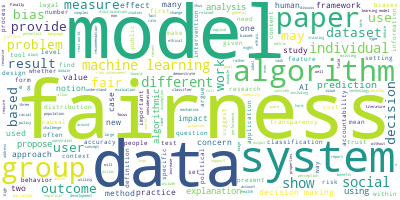

In [6]:
# Academia wordcloud
long_string = ','.join(list(academia))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
# wordcloud.to_file(os.path.join("figures", "academia_cloud.png"))
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


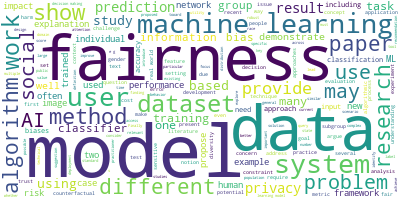

In [7]:
# Industry wordcloud
long_string = ','.join(list(industry))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
# wordcloud.to_file(os.path.join("figures", "industry_cloud.png"))
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


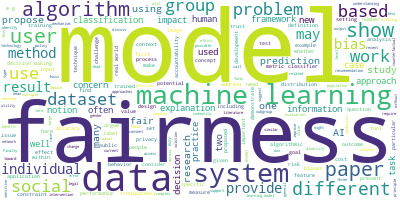

In [8]:
# Entire dataset wordcloud
long_string = ','.join(list(full_dataset))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### TF-IDF reweighting

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


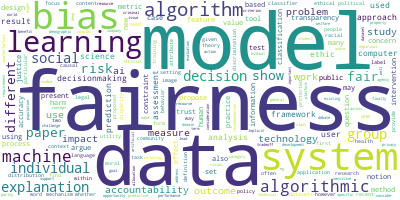

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# convert each doc to strings
academia_clean_doc = [" ".join(doc) for doc in academia_clean]
industry_clean_doc = [" ".join(doc) for doc in industry_clean]

vectorizer = TfidfVectorizer()
academia_tfidf = vectorizer.fit_transform(academia_clean_doc)
feature_names = vectorizer.get_feature_names()

academia_dense = academia_tfidf.todense()
denselist = academia_dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose().sum(axis=1)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(df)
wordcloud.to_image()

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


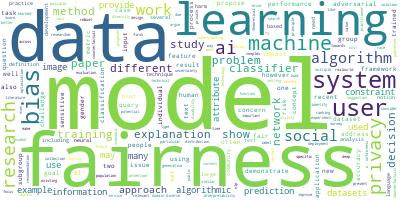

In [10]:
vectorizer = TfidfVectorizer()
industry_tfidf = vectorizer.fit_transform(industry_clean_doc)
feature_names = vectorizer.get_feature_names()

industry_dense = industry_tfidf.todense()
denselist = industry_dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose().sum(axis=1)

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate_from_frequencies(df)
wordcloud.to_image()

## LDA visualization

In [51]:
from gensim.models.ldamodel import LdaModel
from gensim.models import HdpModel
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
sns.set_theme()

Perform topic visualization on entire dataset. Compare coherence for topic #s 2-5.

In [45]:
# Full Dataset
lda_models = {}
topic_range = np.arange(2, 26)
for i in topic_range:
    lda_models[i] = LdaModel(full_term_matrix, num_topics=i, id2word=full_dict, passes=50)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# get coherence of the different lda models
model_list = [lda_models[i] for i in topic_range]
cm = CoherenceModel.for_models(model_list, full_dict, corpus=full_term_matrix, coherence='u_mass')

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


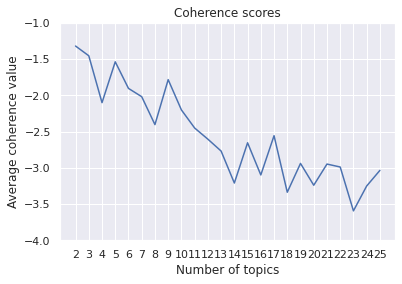

In [48]:
coherence_vals = [tup[1] for tup in cm.compare_models(model_list)]
plt.plot(np.array([i for i in topic_range]), coherence_vals)
plt.ylim(-4, -1)
plt.xticks(topic_range)
plt.xlabel("Number of topics")
plt.ylabel("Average coherence value")
plt.title("Coherence scores")
plt.savefig("figures/copherence_topics.png")

In [53]:
lda_display = gensimvis.prepare(lda_models[14], full_term_matrix, full_dict, R=15, sort_topics=False)
pyLDAvis.save_html(lda_display, open("./figures/lda_vis_14.html", "w"))
pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
lda_display = gensimvis.prepare(lda_models[2], full_term_matrix, full_dict, R=15, sort_topics=False)
pyLDAvis.save_html(lda_display, open("./figures/lda_vis_2.html", "w"))
pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
hdp = HdpModel(full_term_matrix, full_dict)
alpha = hdp.hdp_to_lda()[0]
print((alpha > 0.025).sum())

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


12


/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


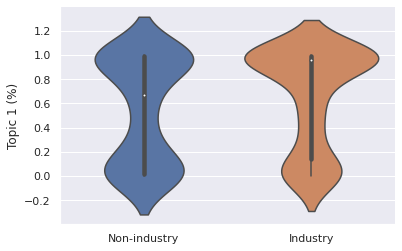

In [62]:
# Examine topic distribution among industry & academic papers
aca_docs = [full_dict.doc2bow(doc) for doc in academia_clean]
industry_docs = [full_dict.doc2bow(doc) for doc in industry_clean]

# for i in range(len(full_term_matrix)):
#     print(lda2.get_document_topics(full_term_matrix[i]))

# visualize in topic space
acad_pts = []
industry_pts = []
labels = []

def generate_point(topic_dist):
    primary_topic = topic_dist[0][0]
    pct_topic = topic_dist[0][1]
    point = [0, 0]
    point[primary_topic] = pct_topic
    point[1 - primary_topic] = 1 - pct_topic
    return point

for i in range(len(aca_docs)):
    topic_dist = lda_models[2].get_document_topics(aca_docs[i])
    acad_pts.append(generate_point(topic_dist))
    labels.append("Non-industry")
    
for i in range(len(industry_docs)):
    topic_dist = lda_models[2].get_document_topics(industry_docs[i])
    industry_pts.append(generate_point(topic_dist))
    labels.append("Industry")
    
# restrict to topic 1
topic_1 = np.array(acad_pts + industry_pts)[:, 0]

ax = sns.violinplot(x=labels, y=topic_1)
ax.set(ylabel="Topic 1 (%)")
sns.despine()
fig = ax.get_figure()
fig.savefig("figures/industry_topic.png")

In [63]:
# # Academia
# ldamodel = LdaModel(academia_term_matrix, num_topics=3, id2word=academia_dict, passes=50)
# lda_display = gensimvis.prepare(ldamodel, academia_term_matrix, academia_dict, sort_topics=False)
# pyLDAvis.display(lda_display)

# # Industry
# ldamodel = LdaModel(industry_term_matrix, num_topics=5, id2word=industry_dict, passes=50)
# lda_display = gensimvis.prepare(ldamodel, industry_term_matrix, industry_dict, sort_topics=False)
# pyLDAvis.display(lda_display)

/home/mattsun/anaconda3/envs/cos524/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Binary Classification

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_curve, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, make_scorer, balanced_accuracy_score
from sklearn.base import clone
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
import xgboost as xgb
import pickle as pkl
import warnings
warnings.filterwarnings('ignore') 

xgb.set_config(verbosity=0)

In [32]:
# dataset of cleaned documents
# x_academia = [' '.join(doc) for doc in academia_clean]
x_academia = academia
y_academia = [0]*len(x_academia)
# x_industry = [' '.join(doc) for doc in industry_clean]
x_industry = industry
y_industry = [1]*len(x_industry)
X = x_academia + x_industry
y = y_academia + y_industry

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [34]:
# define featurizers
featurizers = {
    "tfidf": TfidfVectorizer(),
    "bow": CountVectorizer(),
}

# define classifiers
classifiers = {
    "xgboost": xgb.XGBClassifier(objective="binary:logistic", seed=1337),
    "logistic regression": LogisticRegression(),
    "multinomial nb": MultinomialNB(),
    "svc": SVC(),
}

param_grids = {
    "logistic regression": {
        "clf__C" : [100, 10, 1, 1e-1]
    },
    "multinomial nb": {
        "clf__alpha": np.linspace(0.5, 1.5, 6),
        "clf__fit_prior": [True, False],  
    },
    "svc": {
        'clf__C': np.logspace(-1, 3, base = 10, num=4),  
        'clf__gamma': [1, 0.1, 0.01], 
    },
    "xgboost": {
        'clf__learning_rate': [0.03, 0.05, 0.07], #so called `eta` value
        'clf__max_depth': [4, 6, 8],
        'clf__subsample': [0.6, 0.7, 0.8],
        'clf__colsample_bytree': [0.3, 0.5, 0.7],
        'clf__n_estimators': [5, 200, 400, 1000], #number of trees, change it to 1000 for better results
    }
}

scoring = {
    'acc': 'accuracy',
    'balanced_acc': 'balanced_accuracy',
    'pos_prec': 'precision',
    'pos_rec': 'recall',
    'f1': 'f1',
    'auc_roc': 'roc_auc'
}

# utils for printing performance
def mean_and_std(scores):
    """ Return string with mean & stdev"""
    arr = np.array(scores)
    return f"{arr.mean():0.4f} (SD: {arr.std():0.4f})" 

def print_scores(scores, num_folds=5):
    print()
    print("Validation statistics of best model")
    print("-----------------------")
    print(f"{num_folds}-fold CV Val Accuracy:\t\t{mean_and_std(scores['test_acc'])}")
    print(f"{num_folds}-fold CV Val Balanced Accuracy:\t\t{mean_and_std(scores['test_balanced_acc'])}")
    print(f"{num_folds}-fold CV Val Precision (Industry):\t\t{mean_and_std(scores['test_pos_prec'])}")
    print(f"{num_folds}-fold CV Val Recall (Industry):\t\t{mean_and_std(scores['test_pos_rec'])}")
    print(f"{num_folds}-fold CV Val F1:\t\t{mean_and_std(scores['test_f1'])}")
    print(f"{num_folds}-fold CV Val ROC AUC:\t\t{mean_and_std(scores['test_auc_roc'])}")
    print()
    print("Training statistics of best model")
    print("-----------------------")
    print(f"{num_folds}-fold CV Train Accuracy:\t\t{mean_and_std(scores['train_acc'])}")
    print(f"{num_folds}-fold CV Train Balanced Accuracy:\t\t{mean_and_std(scores['train_balanced_acc'])}")
    print(f"{num_folds}-fold CV Train Precision (Industry):\t\t{mean_and_std(scores['train_pos_prec'])}")
    print(f"{num_folds}-fold CV Train Recall (Industry):\t\t{mean_and_std(scores['train_pos_rec'])}")
    print(f"{num_folds}-fold CV Train F1:\t\t{mean_and_std(scores['train_f1'])}")
    print(f"{num_folds}-fold CV Train ROC AUC:\t\t{mean_and_std(scores['train_auc_roc'])}")
    print()

Training xgboost classifier using tfidf featurizer...

Validation statistics of best model
-----------------------
5-fold CV Val Accuracy:		0.7141 (SD: 0.0388)
5-fold CV Val Balanced Accuracy:		0.6798 (SD: 0.0175)
5-fold CV Val Precision (Industry):		0.7056 (SD: 0.0383)
5-fold CV Val Recall (Industry):		0.8929 (SD: 0.1317)
5-fold CV Val F1:		0.7815 (SD: 0.0468)
5-fold CV Val ROC AUC:		0.7650 (SD: 0.0880)

Training statistics of best model
-----------------------
5-fold CV Train Accuracy:		1.0000 (SD: 0.0000)
5-fold CV Train Balanced Accuracy:		1.0000 (SD: 0.0000)
5-fold CV Train Precision (Industry):		1.0000 (SD: 0.0000)
5-fold CV Train Recall (Industry):		1.0000 (SD: 0.0000)
5-fold CV Train F1:		1.0000 (SD: 0.0000)
5-fold CV Train ROC AUC:		1.0000 (SD: 0.0000)

Best CV parameters:
{'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 400, 'clf__subsample': 0.6}

Accuracy score (entire train set): 1.0
Confusion matrix (training set):
[[26 

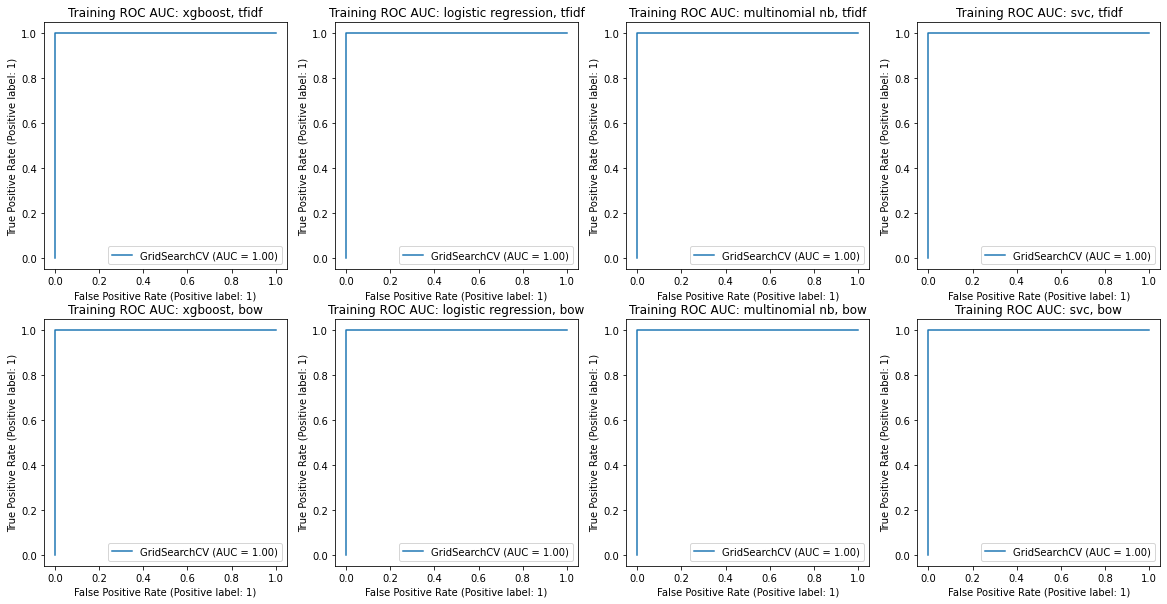

In [35]:
# refit based on highest accuracy
refit='acc'
models = {} # store best performing models

plt.figure(1, figsize=(20,10))
rows = len(featurizers)
cols = len(classifiers)
num_folds = 5
plotnum = 0
for fname, f in featurizers.items():
    for cname, c in classifiers.items():
        print(f"Training {cname} classifier using {fname} featurizer...")
        # construct pipeline of vectorizer and classifier
        pipeline = Pipeline([('vec', f),('clf', c)])
        
        # perform CV grid search
        clf = GridSearchCV(pipeline, param_grids[cname], cv=num_folds, scoring=scoring, refit=refit, return_train_score=True)
        clf.fit(X_train, y_train)
        # store fitted best model
        models[(fname, cname)] = clf
        
        # get cross validated scores for the best estimator
        scores = cross_validate(clone(clf.best_estimator_), X_train, y_train, cv=num_folds, scoring=scoring, return_train_score=True)
        print_scores(scores, num_folds=num_folds)
        print("Best CV parameters:")
        print(clf.best_params_)
        
        # plot training ROC AUC
        plotnum += 1
        ax = plt.subplot(rows, cols, plotnum)
        disp = plot_roc_curve(clf, X_train, y_train, ax=ax)
        disp.ax_.set_title(f"Training ROC AUC: {cname}, {fname}")
        
        # display metrics of interest on full training data set
        prediction = clf.predict(X_train)
        print()
        print(f"Accuracy score (entire train set): {accuracy_score(y_train, prediction)}")
        print("Confusion matrix (training set):")
        # Rows = true labels
        # Cols = predicted labels
        print(confusion_matrix(y_train, prediction))
        print()

In [56]:
def save_models(models, filename):
    with open(filename, "wb") as file:
        pkl.dump(models, file, -1)

def load_models(filename):
    return pkl.load(open(filename, "rb"))

save_models(models, "saved_models/models_nostop.pkl")

In [40]:
# inspect logistic BOW

model = models[("tfidf", "logistic regression")].best_estimator_


feature_names = (model.named_steps['vec']
                      .get_feature_names())

coefs = pd.DataFrame(
    np.array(model.named_steps['clf'].coef_).flatten(),
    columns=['Coefficients'], index=feature_names
)

print("\nMost predictive of industry:")
print(coefs['Coefficients'].nlargest(10))

print("\nMost predictive of academia:")
print(coefs['Coefficients'].nsmallest(10))


Most predictive of industry:
user           2.788150
feature        2.510514
sharing        1.893852
classifier     1.789043
research       1.786827
security       1.687319
ai             1.670828
query          1.626877
researcher     1.622158
development    1.616346
Name: Coefficients, dtype: float64

Most predictive of academia:
trust         -3.368918
leaveoneout   -2.991388
bias          -2.820826
health        -2.385484
allocation    -2.335206
fairness      -2.237462
related       -2.216675
measure       -2.209158
embeddings    -2.161371
debate        -2.155029
Name: Coefficients, dtype: float64


In [54]:
# find highest accuracy models

# find acc_model with highest validation accuracy
name_and_models = [(k, v) for k, v in models.items()]
top_n = 4
best_acc_models = sorted(name_and_models, key=lambda tup: -1 * tup[1].best_score_)[:top_n]

for bm in best_acc_models:
    print(f"{bm[0]} validation accuracy: {bm[1].best_score_}")

('tfidf', 'xgboost') validation accuracy: 0.7141025641025641
('bow', 'multinomial nb') validation accuracy: 0.6820512820512821
('bow', 'xgboost') validation accuracy: 0.6641025641025641
('tfidf', 'logistic regression') validation accuracy: 0.6628205128205129


Model and featurizer: ('tfidf', 'xgboost')
Accuracy score: 0.5859375
Balanced accuracy score: 0.5709825528007346
F1: 0.6826347305389221

Model and featurizer: ('bow', 'multinomial nb')
Accuracy score: 0.6484375
Balanced accuracy score: 0.6465258647076828
F1: 0.6715328467153284

Model and featurizer: ('bow', 'xgboost')
Accuracy score: 0.609375
Balanced accuracy score: 0.5923477196204469
F1: 0.7093023255813954

Model and featurizer: ('tfidf', 'logistic regression')
Accuracy score: 0.63671875
Balanced accuracy score: 0.6264156718702173
F1: 0.7028753993610223



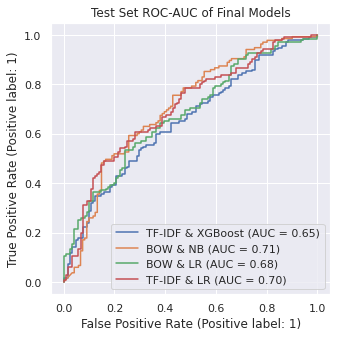

In [55]:
fig, ax = plt.subplots(figsize=(5, 5))

label_map = {
    ('bow', 'logistic regression'): 'BOW & LR',
    ('bow', 'multinomial nb'): 'BOW & NB',
    ('tfidf', 'logistic regression'): 'TF-IDF & LR',
    ('tfidf', 'xgboost'): 'TF-IDF & XGBoost',
    ('bow', 'xgboost'): 'BOW & LR'
}

for bm in best_acc_models:
    model = bm[1].best_estimator_
    print(f"Model and featurizer: {bm[0]}")
    
    prediction = model.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, prediction)}")
    print(f"Balanced accuracy score: {balanced_accuracy_score(y_test, prediction)}")
    print(f"F1: {f1_score(y_test, prediction)}")
    disp = plot_roc_curve(model, X_test, y_test, ax=ax, name=label_map[bm[0]])

    print()

ax.set_title("Test Set ROC-AUC of Final Models")
plt.savefig("figures/test_rocauc.png")